# Neural Network Analysis: Laptop Price

In this project we have used the dataset: https://www.kaggle.com/datasets/muhammetvarl/laptop-price
We have focused on the preprocessing of the data. Necessary columns are prcessed carefully and made ready for regression analysis. Random Forest technique to build a model that fit the data and make prediction of the new observations

#### Importing required Packages

In [124]:
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.manifold import TSNE

#### Loading dataset:
As it is 'utf-8 encoded so it is solved by calling "latin-1" as encoding. 

In [54]:
data = pd.read_csv('laptop_price.csv', encoding = "latin-1")


In [55]:
data.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


### Data Cleaning and Preprocessing

This preprocessing task is done with  the help of **NeuralNine**. I am really thankful.

We drop the column Product as it has no significant effect in the dataset.

In [56]:
data = data.drop("Product", axis = 1)

Here the column "Company" contains all the brand name which are in this dataset. So to train the model properly, one hot encoded is better for this feature. 

In [57]:
data = data.join(pd.get_dummies(data.Company))
data = data.drop("Company", axis =1)

The same things are done for the column "TypeName" as it contains the types of devices. Also the original column is dropped afer the encoding in each category.

In [58]:
data = data.join(pd.get_dummies(data.TypeName))
data = data.drop("TypeName", axis =1)

The Column "ScrenResolution" contains the laptop screen information. Here we take only the resolution which is on the last. Then the screen width and height is separated into two different columns. 

In [59]:
data["ScreenResolution"] = data.ScreenResolution.str.split(" ").apply(lambda x: x[-1])
data["Screen Width"] = data.ScreenResolution.str.split("x").apply(lambda x: x[0])
data["Screen Height"] = data.ScreenResolution.str.split("x").apply(lambda x: x[1])

In [60]:
data = data.drop("ScreenResolution", axis = 1)

From the column Cpu, it has two different information. One is Cpu brand name and the other is it's frequency. Here both of these are separated into two columns. Then the original column is dropped.

In [61]:
data["Cpu Brand"] = data.Cpu.str.split(" ").apply(lambda x: x[0])
data["Cpu Frequency"] = data.Cpu.str.split(" ").apply(lambda x: x[-1])

In [62]:
data = data.drop("Cpu", axis = 1)

In [63]:
data["Cpu Frequency"] = data["Cpu Frequency"].str[:-3]

Text from the Ram column is removed as we need only the ram amount. Same for the weight.

In [64]:
data["Ram"] = data["Ram"].str[:-2]

In [65]:
data["Weight"] = data["Weight"].str[:-2]

The "Memory" column is a little bit complicated. Here firstly we separated the memory amount and memory type. Memory types indicates either it is HDD, SDD or any other drive and the amount indicates the memory size. But the memory size has different parameters e.g. GB, TB. So we need to convert them into a same scale. Here we pass the memory amount column into a function to convert the memory size to the MB scale. Then all the values will be in same scale.

In [66]:
data["Memory Amount"] = data.Memory.str.split(" ").apply(lambda x: x[0])
data["Memory_Type"] = data.Memory.str.split(" ").apply(lambda x: x[-1])

In [67]:
data = data.drop("Memory", axis = 1)

In [68]:
def memory_into_MB(value):
    if "GB" in value:
        return float(value[:value.find("GB")])*1000
    elif "TB" in value:
        return float(value[:value.find("TB")])*1000000

In [69]:
data["Memory Amount"] = data["Memory Amount"].apply(memory_into_MB)

In [70]:
data = data.join(pd.get_dummies(data.Memory_Type))
data = data.drop("Memory_Type", axis =1)

Operating system column are also treated as one hot encoder as different types of operating system has a significant effect in the laptop price. 

In [71]:
data = data.join(pd.get_dummies(data.OpSys))
data = data.drop("OpSys", axis =1)

Only need the GPU brand to compare the marketprice of the GPU. So the GPU brand name is saperated from the "Gpu" column and dropped the previous one.

In [72]:
data["Gpu Brand"] = data.Gpu.str.split(" ").apply(lambda x: x[0])

In [73]:
data = data.drop("Gpu", axis = 1)

Since GPU and CPU have the same branding name so to distinguish between them, both of the colunm's brand name is categorised. List comprehension technique is used here to make them separated with dummy columns.

In [74]:
cpu_categories = pd.get_dummies(data["Cpu Brand"])
cpu_categories.columns = [col + "_CPU" for col in cpu_categories.columns]

In [75]:
data = data.join(cpu_categories)
data = data.drop("Cpu Brand", axis = 1)

In [76]:
gpu_categories = pd.get_dummies(data["Gpu Brand"])
gpu_categories.columns = [col + "_GPU" for col in gpu_categories.columns]

In [77]:
data = data.join(gpu_categories)
data = data.drop("Gpu Brand", axis = 1)

As some of the integer values are taken from the string values, they need to be converted as an integer. Here, Screen height and width, Ram, Cpu frequency, Wight are converted from string to integer

In [78]:
data["Screen Width"] = data["Screen Width"].astype("int")
data["Screen Height"] = data["Screen Height"].astype("int")

In [79]:
data["Ram"] = data["Ram"].astype("int")
data["Cpu Frequency"] = data["Cpu Frequency"].astype("float")

In [80]:
data["Weight"] = data["Weight"].astype(float)

In [81]:
columns_to_convert = ['Acer', 'Apple',
       'Asus', 'Chuwi', 'Dell', 'Fujitsu', 'Google', 'HP', 'Huawei', 'LG',
       'Lenovo', 'MSI', 'Mediacom', 'Microsoft', 'Razer', 'Samsung', 'Toshiba',
       'Vero', 'Xiaomi', '2 in 1 Convertible', 'Gaming', 'Netbook', 'Notebook',
       'Ultrabook', 'Workstation', 'HDD', 'Hybrid', 'SSD', 'Storage',
       'Android', 'Chrome OS', 'Linux', 'Mac OS X', 'No OS', 'Windows 10',
       'Windows 10 S', 'Windows 7', 'macOS', 'AMD_CPU', 'Intel_CPU',
       'Samsung_CPU', 'AMD_GPU', 'ARM_GPU', 'Intel_GPU', 'Nvidia_GPU']

In [82]:
data[columns_to_convert] = data[columns_to_convert].astype(int)

### Correlation analysis

In [83]:
data.corr()

,laptop_ID,Inches,Ram,Weight,Price_euros,Acer,Apple,Asus,Chuwi,Dell,...,Windows 10 S,Windows 7,macOS,AMD_CPU,Intel_CPU,Samsung_CPU,AMD_GPU,ARM_GPU,Intel_GPU,Nvidia_GPU
laptop_ID,1.000000,-0.087796,-0.028607,-0.011798,0.067830,-0.057721,-0.119585,-0.044252,-0.043348,-0.013628,...,-0.061942,0.194094,-0.158931,-0.055338,0.049765,0.039920,-0.089050,0.039920,0.094479,-0.037596
Inches,-0.087796,1.000000,0.237993,0.827631,0.068197,0.009435,-0.158850,0.112766,-0.017426,0.045288,...,-0.093285,-0.064775,-0.100867,0.129801,-0.122000,-0.052816,0.207023,-0.052816,-0.592264,0.486561
Ram,-0.028607,0.237993,1.000000,0.383874,0.743007,-0.138432,0.023950,0.088634,-0.035117,0.082241,...,-0.021374,-0.017529,0.028914,-0.104759,0.107051,-0.023894,-0.093119,-0.023894,-0.319551,0.415464
Weight,-0.011798,0.827631,0.383874,1.000000,0.210370,0.056444,-0.138191,0.101332,-0.022536,0.088465,...,-0.087904,-0.048100,-0.096042,0.062641,-0.057386,-0.037026,0.106519,-0.037026,-0.596378,0.565232
Price_euros,0.067830,0.068197,0.743007,0.210370,1.000000,-0.208349,0.080688,-0.010376,-0.055646,0.048509,...,0.018312,0.152381,0.089928,-0.180111,0.181127,-0.018431,-0.199415,-0.018431,-0.184205,0.348797
Acer,-0.057721,0.009435,-0.138432,0.056444,-0.208349,1.000000,-0.037497,-0.108831,-0.014074,-0.159187,...,-0.023027,-0.055411,-0.029411,0.068130,-0.066566,-0.008119,-0.034859,-0.008119,0.005305,0.020848
Apple,-0.119585,-0.158850,0.023950,-0.138191,0.080688,-0.037497,1.000000,-0.047544,-0.006148,-0.069542,...,-0.010059,-0.024206,0.784352,-0.028607,0.028849,-0.003547,0.001749,-0.003547,0.078028,-0.085183
Asus,-0.044252,0.112766,0.088634,0.101332,-0.010376,-0.108831,-0.047544,1.000000,-0.017845,-0.201839,...,0.030999,-0.070257,-0.037291,0.038455,-0.036835,-0.010295,-0.073770,-0.010295,-0.106654,0.170742
Chuwi,-0.043348,-0.017426,-0.035117,-0.022536,-0.055646,-0.014074,-0.006148,-0.017845,1.000000,-0.026102,...,-0.003776,-0.009086,-0.004822,-0.010737,0.010828,-0.001331,-0.019232,-0.001331,0.043093,-0.031972
Dell,-0.013628,0.045288,0.082241,0.088465,0.048509,-0.159187,-0.069542,-0.201839,-0.026102,1.000000,...,-0.042706,-0.032633,-0.054545,-0.121448,0.122473,-0.015058,0.190722,-0.015058,-0.075707,-0.060187


<Axes: >

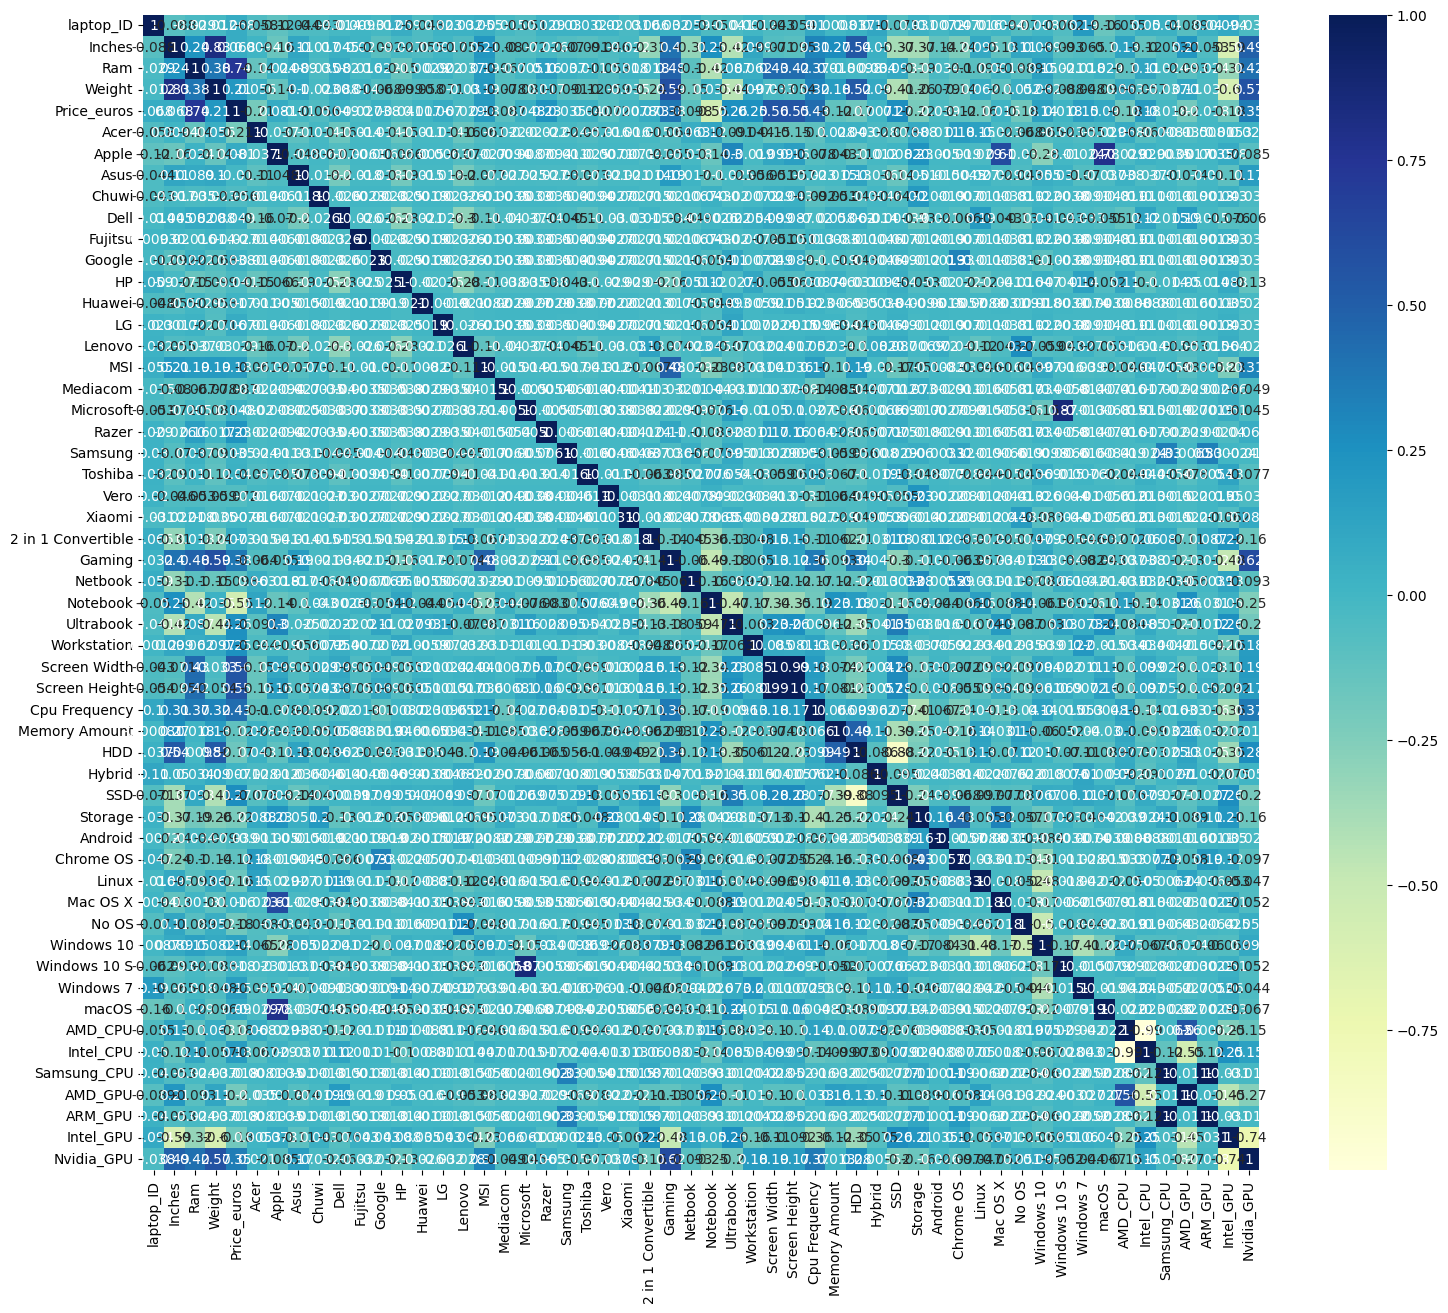

In [84]:
plt.figure(figsize=(18,15))
sns.heatmap(data.corr(), annot =True, cmap = "YlGnBu")

From the above dataframe and the figure, it is seen that a lot of features are included in the entire dataset. But all the features are not relavent. So it is better to reduce them into 20 important features and continue with further analysis.

In [85]:
target_correlations = data.corr()['Price_euros'].apply(abs).sort_values()

In [86]:
target_correlations

Xiaomi                0.000776
Hybrid                0.007051
Asus                  0.010376
Mac OS X              0.015656
Huawei                0.016851
Windows 10 S          0.018312
ARM_GPU               0.018431
Samsung_CPU           0.018431
Fujitsu               0.027135
Lenovo                0.029007
Samsung               0.034584
Google                0.038086
Android               0.038700
Toshiba               0.040339
HP                    0.041291
Microsoft             0.047562
Dell                  0.048509
Chuwi                 0.055646
LG                    0.067053
laptop_ID             0.067830
Inches                0.068197
Vero                  0.071972
2 in 1 Convertible    0.072675
Apple                 0.080688
Mediacom              0.087161
macOS                 0.089928
Netbook               0.097572
Chrome OS             0.118684
Memory Amount         0.122365
Windows 10            0.137048
Windows 7             0.152381
Linux                 0.162060
HDD     

In [87]:
selected_features = target_correlations[-21:].index

In [88]:
selected_features = list(selected_features)

In [89]:
limited_data = data[selected_features]

In [90]:
limited_data.head()

,No OS,MSI,AMD_CPU,Intel_CPU,Intel_GPU,AMD_GPU,Acer,Weight,Storage,Razer,...,Ultrabook,SSD,Nvidia_GPU,Gaming,Cpu Frequency,Notebook,Screen Height,Screen Width,Ram,Price_euros
0,0,0,0,1,1,0,0,1.37,0,0,...,1,1,0,0,2.3,0,1600,2560,8,1339.69
1,0,0,0,1,1,0,0,1.34,1,0,...,1,0,0,0,1.8,0,900,1440,8,898.94
2,1,0,0,1,1,0,0,1.86,0,0,...,0,1,0,0,2.5,1,1080,1920,8,575.00
3,0,0,0,1,0,1,0,1.83,0,0,...,1,1,0,0,2.7,0,1800,2880,16,2537.45
4,0,0,0,1,1,0,0,1.37,0,0,...,1,1,0,0,3.1,0,1600,2560,8,1803.60


<Axes: >

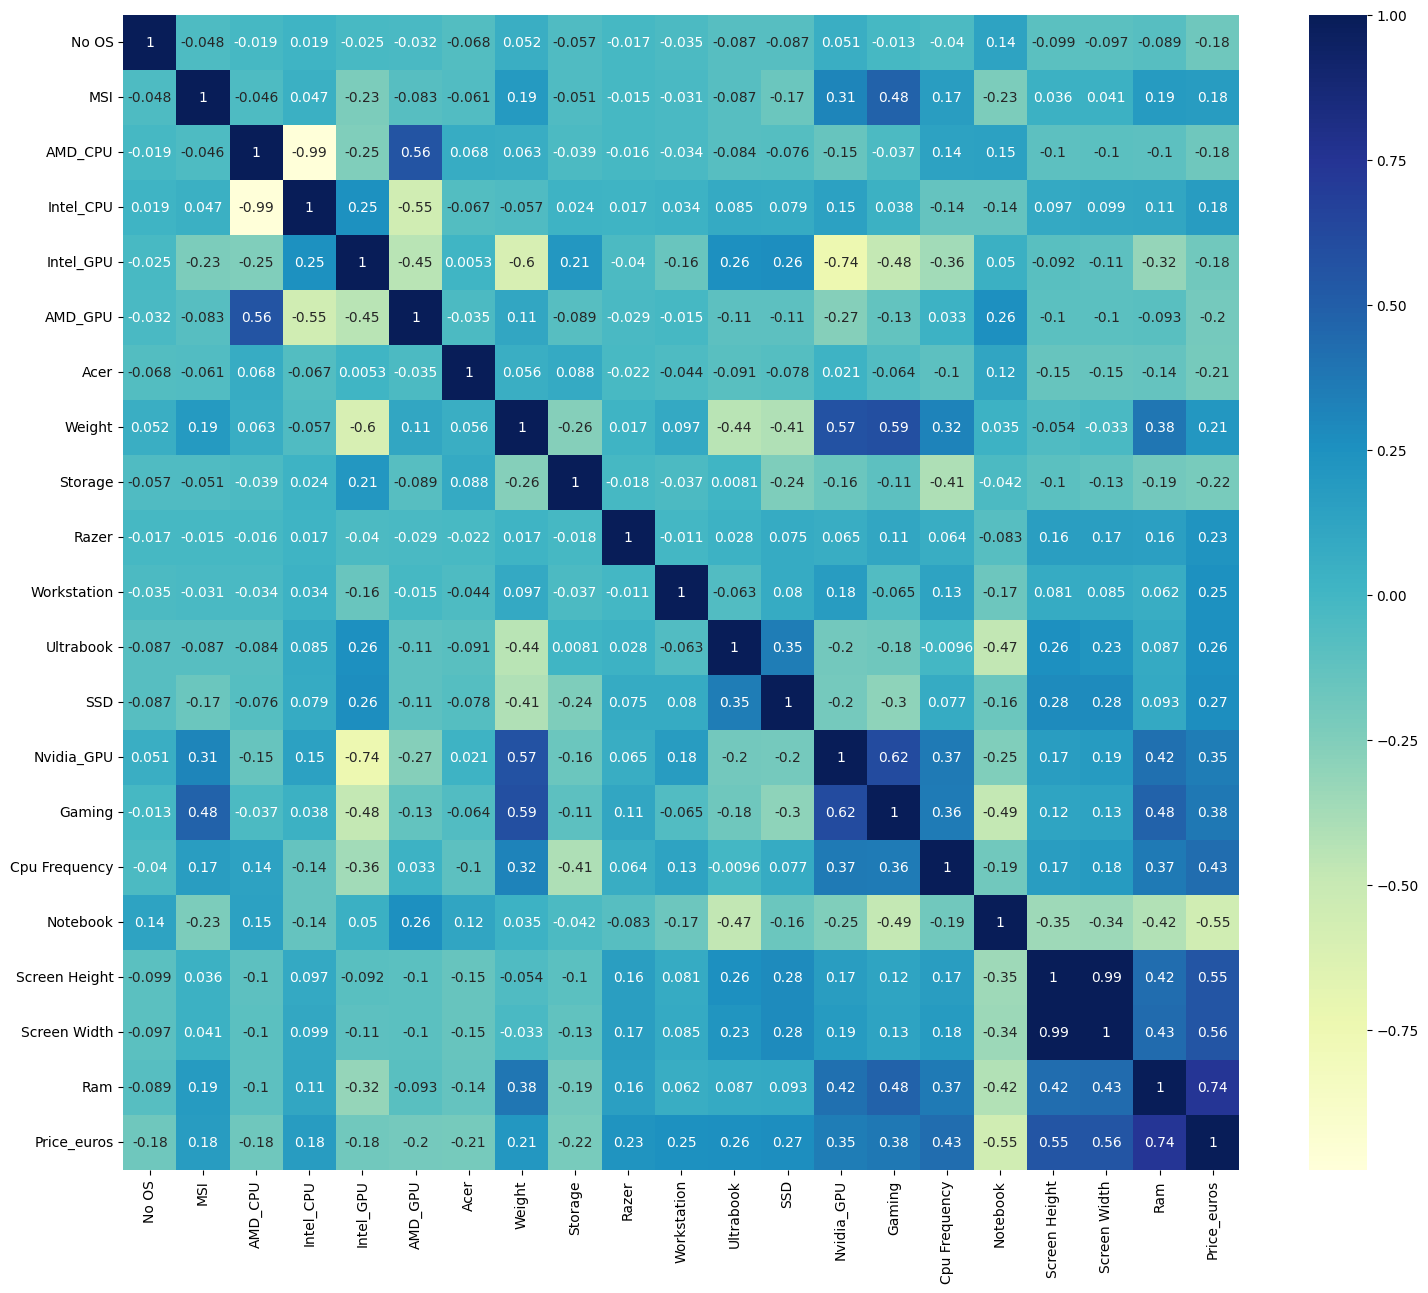

In [91]:
plt.figure(figsize=(18,15))
sns.heatmap(limited_data.corr(), annot =True, cmap = "YlGnBu")

Now it is better to explore the dataset with a meaningful way.

### Regression Analysis: Predict Laptop Price

Split the dataset into train and test set with dependent and independent variables. Also it is needed to scale the training data.

In [92]:
X, y = limited_data.drop("Price_euros", axis = 1), limited_data["Price_euros"]

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.15)

In [94]:
scaler = StandardScaler()

In [95]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random Forest is used to predict the laptop price in euros as the dataframe contains a lot of features.

In [96]:
forest = RandomForestRegressor()
forest.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [97]:
y_pred = forest.predict(X_test_scaled)

Visualization of the model, fitted in our processed dataframe.

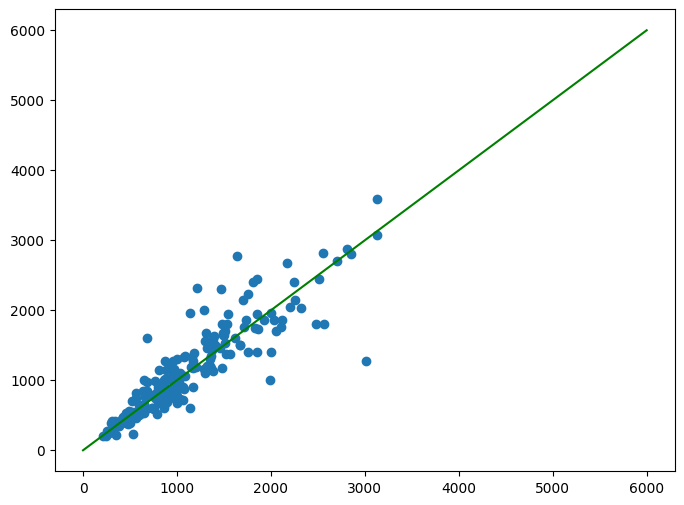

In [98]:
plt.figure(figsize = (8,6))
plt.scatter(y_pred, y_test)
plt.plot(range(0,6000), range(0,6000), c = "green" )

In [99]:
X_new_scaled = scaler.transform([X_test.iloc[0]])

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Evaluating the model with a random guess.

In [100]:
forest.score(X_test_scaled, y_test)

0.7940329650313862

In [101]:
forest.predict(X_new_scaled)

array([1351.10882567])

In [102]:
y_test.iloc[0]

1199.0

### Cluster Analysis

Objective: Group laptops into clusters based on similar features. 

Algorithms: K-Means Clustering

Steps:
- Preprocessing: Standardize the features to ensure they contribute equally to the clustering.
- Model Training: Apply the clustering algorithm to the dataset.
- Evaluation: Use metrics like Silhouette Score or visualize clusters to interpret the results.

Dropping the target column 'Price_euros' for clustering and Standardize the features

In [103]:
features = limited_data.drop('Price_euros', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

Here we now determine the optimal number of clusters using the elbow method and plot the curve

In [106]:
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

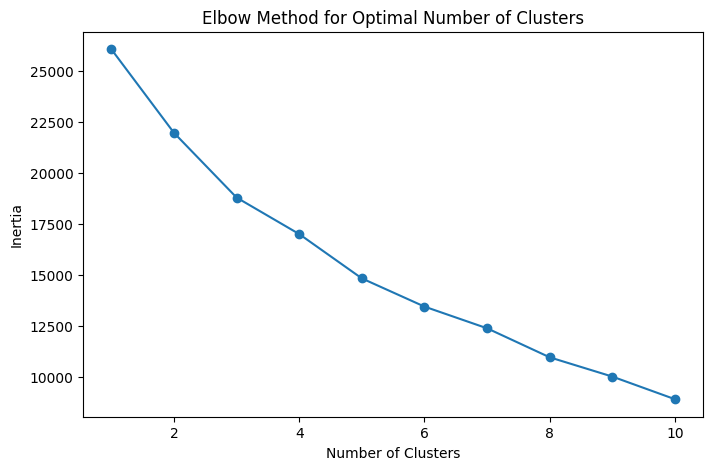

In [107]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

From the plot, we choose the optimal number of clusters (e.g., 3). Then we add the cluster labels to the original datasets

In [108]:
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

limited_data['Cluster'] = cluster_labels

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_33/3141266157.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_data['Cluster'] = cluster_labels


Since we have many features, we'll use PCA to reduce the dimensions to 2 for visualization.

First we reduce the features to 2D for visualization.

In [110]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

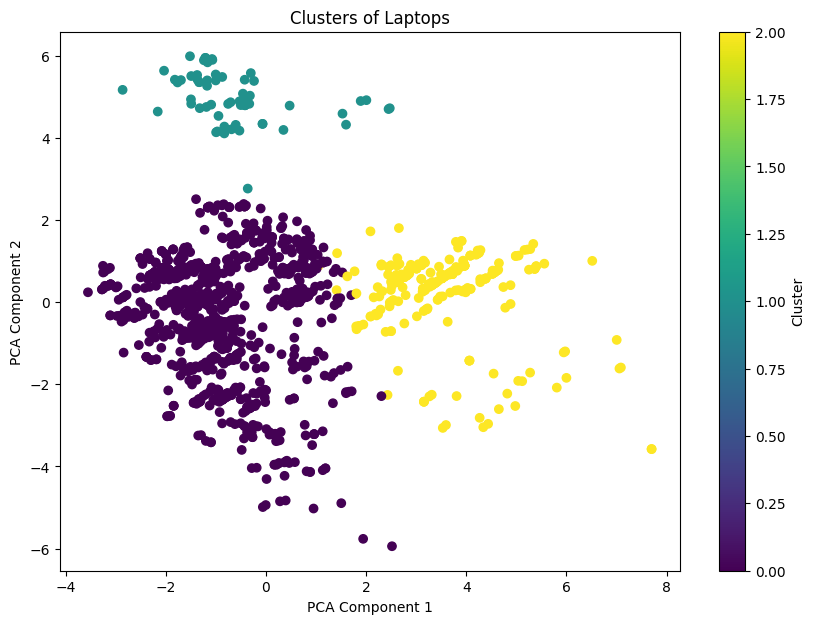

In [111]:
plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis', marker='o')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters of Laptops')
plt.colorbar(label='Cluster')
plt.show()

### Classification Analysis with Neural Network

We'll use TensorFlow and Keras to build and train the neural network model.

In [113]:
X = limited_data.drop(['Gaming', 'Price_euros'], axis=1)
y = limited_data['Gaming']

# Ensure the target is binary
assert y.nunique() == 2, "Target variable 'Gaming' must be binary."

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

We define the neural network model. Then we compile the model and the train it.

In [114]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7836 - loss: 0.4740 - val_accuracy: 0.9770 - val_loss: 0.1023
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0779 - val_accuracy: 0.9808 - val_loss: 0.0608
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9809 - loss: 0.0677 - val_accuracy: 0.9885 - val_loss: 0.0399
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0222 - val_accuracy: 0.9923 - val_loss: 0.0322
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0213 - val_accuracy: 0.9885 - val_loss: 0.0357
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0206 - val_accuracy: 0.9885 - val_loss: 0.0378
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0119 - val_accuracy: 0.9923 - val_loss: 0.0324
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0154 - val_accuracy: 0.9885 - val_

We evaluate the model on the test set and Calculate the evaluation matrics

In [115]:
y_pred = (model.predict(X_test) > 0.5).astype("int64")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=1)
recall = recall_score(y_test, y_pred, zero_division=1)
f1 = f1_score(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.99
Precision: 0.95
Recall: 1.00
F1 Score: 0.97


### Dimensionality Reduction

let's perform dimensionality reduction on the dataset using PCA, t-SNE, and UMAP. We'll follow these steps:

* Preprocessing: Standardize the features.
* Model Training: Apply PCA, t-SNE, and UMAP to the dataset.
* Visualization: Visualize the reduced dimensions to interpret patterns and relationships in the data.

#### Apply PCA

In [117]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

Now we plot the PCA results

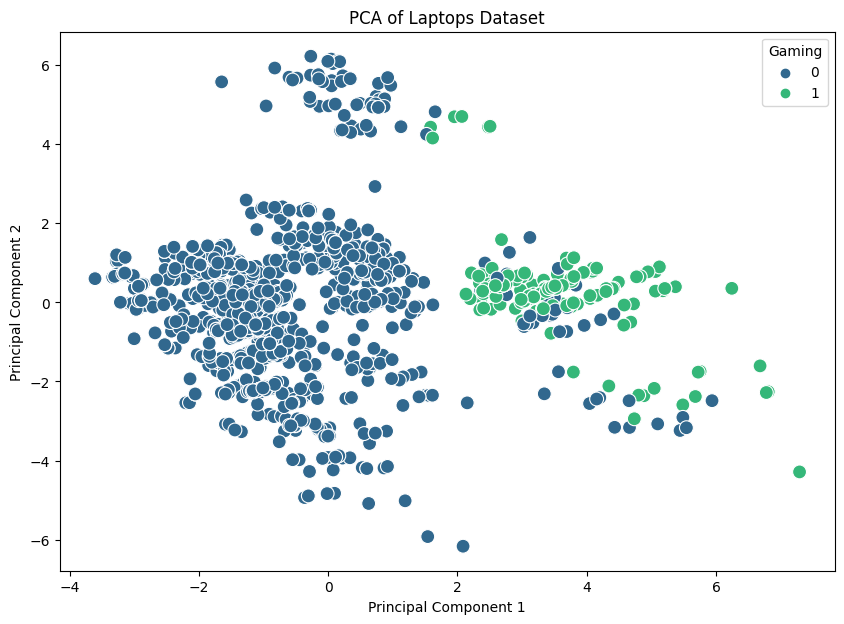

In [118]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=limited_data['Gaming'], palette='viridis', s=100)
plt.title('PCA of Laptops Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### Apply t-SNE

In [120]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

Plot the t-SNE results

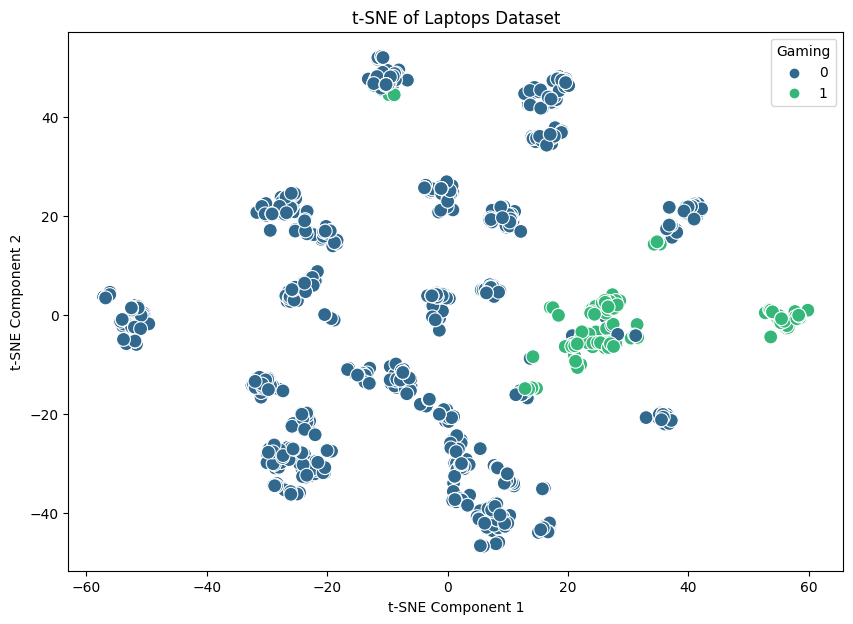

In [121]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=limited_data['Gaming'], palette='viridis', s=100)
plt.title('t-SNE of Laptops Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

#### Apply umapp

In [128]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_scaled)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


 Plot the UMAP results

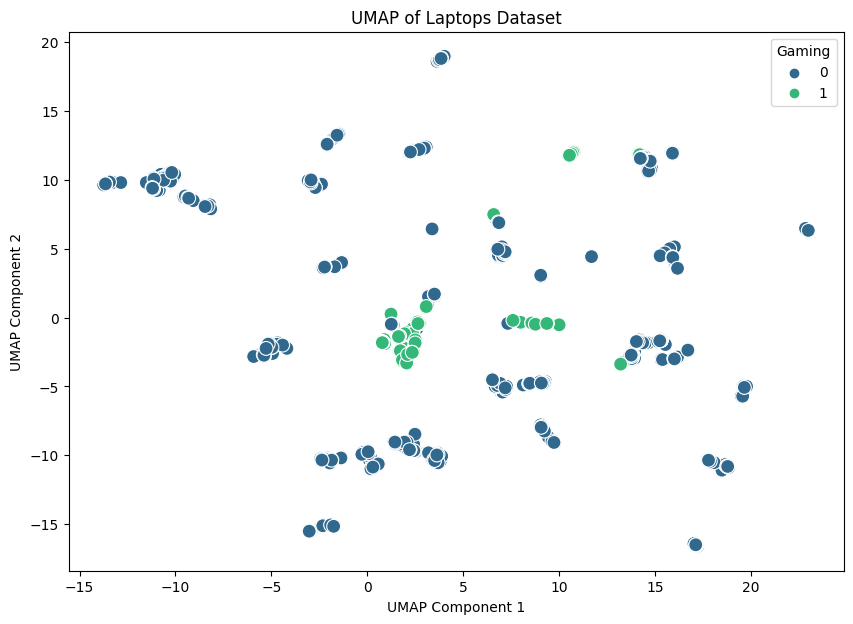

In [129]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=limited_data['Gaming'], palette='viridis', s=100)
plt.title('UMAP of Laptops Dataset')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()